In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Load Dataset
df = pd.read_csv("/content/asag_dataset_selected.csv")
df = df.dropna()  # Remove missing values
print(df.info())
print(df.describe())

vectorizer = TfidfVectorizer()

# Fit and transform required text columns
tfidf_matrix = vectorizer.fit_transform(df['student_answer'].astype(str) + df['ref_answer'].astype(str))

# Compute cosine similarity function
def get_cosine_sim(text1, text2):
    vecs = vectorizer.transform([text1, text2])
    return cosine_similarity(vecs[0], vecs[1])[0][0]
df['cos_similarity'] = df.apply(lambda row: get_cosine_sim(row['student_answer'], row['ref_answer']), axis=1)
df['cos_similarity_demo'] = df.apply(lambda row: get_cosine_sim(row['aligned'], row['ref_answer']), axis=1)

# Compute length ratio
df['length_ratio'] = df['student_answer'].str.len() / df['ref_answer'].str.len()

# Display results
print(df[['cos_similarity', 'cos_similarity_demo', 'length_ratio']].head())

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 644
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   question            607 non-null    object 
 1   student_answer      607 non-null    object 
 2   grades_round        607 non-null    int64  
 3   ref_answer          607 non-null    object 
 4   aligned             607 non-null    object 
 5   aligned_score       607 non-null    float64
 6   aligned_score_demo  607 non-null    float64
 7   question_id         607 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 42.7+ KB
None
       grades_round  aligned_score  aligned_score_demo  question_id
count    607.000000     607.000000          607.000000   607.000000
mean       1.457990       0.387494            0.340137     8.815486
std        0.655868       0.159650            0.160495     4.846375
min        0.000000       0.000000            0.000000     1.000000
25%

In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.0 MB/s eta 0:00:00


In [ ]:
import spacy
from textstat import flesch_reading_ease

# Load English tokenizer
nlp = spacy.load("en_core_web_sm")

def preprocess_text_spacy(text):
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop])
df["student_modified"] = df["student_answer"].astype(str).apply(preprocess_text_spacy)
df["ref_modified"] = df["ref_answer"].astype(str).apply(preprocess_text_spacy)

def clarity_score(text):
    return flesch_reading_ease(text)
df["student_clarity"] = df["student_answer"].astype(str).apply(clarity_score)
df["ref_clarity"] = df["ref_answer"].astype(str).apply(clarity_score)

print(df["student_clarity"].head())
print(df["ref_clarity"].head())

0    46.27
1    45.12
2    25.46
3    33.75
4    43.43
Name: student_clarity, dtype: float64
0    33.95
1    33.95
2    33.95
3    33.95
4    33.95
Name: ref_clarity, dtype: float64


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def ngram_overlap_sklearn(student_answer, reference_answer, n):
    vectorizer = CountVectorizer(ngram_range=(n, n))

    # Fit on combined text but transform separately
    vectorizer.fit([student_answer, reference_answer])

    student_ngrams = set(vectorizer.transform([student_answer]).nonzero()[1])
    reference_ngrams = set(vectorizer.transform([reference_answer]).nonzero()[1])

    overlap = student_ngrams.intersection(reference_ngrams)
    overlap_ratio = len(overlap) / len(student_ngrams) if len(student_ngrams) > 0 else 0
    return overlap_ratio


# Apply bigram overlap
df["bigram_overlap"] = df.apply(lambda row: ngram_overlap_sklearn(row["student_answer"], row["ref_answer"], 2), axis=1)



In [ ]:
print(df[["student_modified", "ref_modified"]].head())

                                    student_modified  \
0  artificial neural network massively parallel d...   
1  artificial neural network consist largely para...   
2  artificial neural network massive distribute p...   
3  ann layered graphical model contain neuron wei...   
4  artificial neural network large parallel proce...   

                                        ref_modified  
0  neural network massively parallel distribute p...  
1  neural network massively parallel distribute p...  
2  neural network massively parallel distribute p...  
3  neural network massively parallel distribute p...  
4  neural network massively parallel distribute p...  


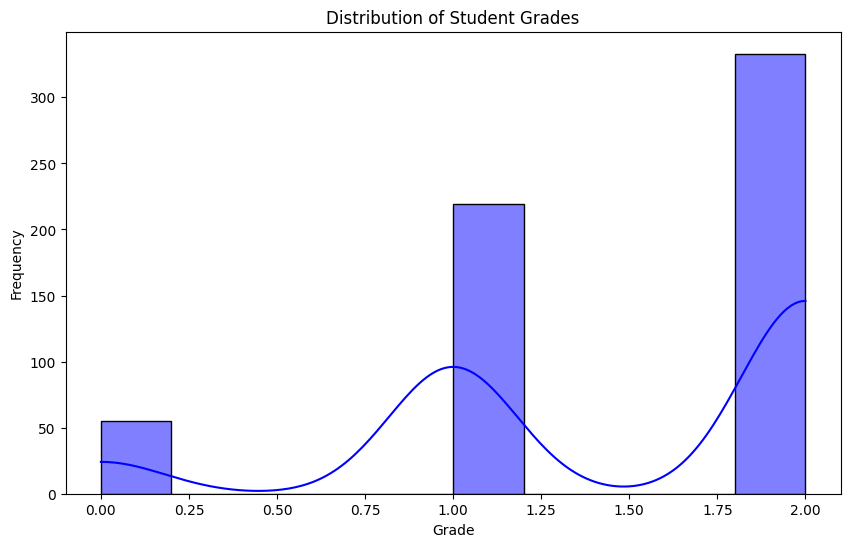

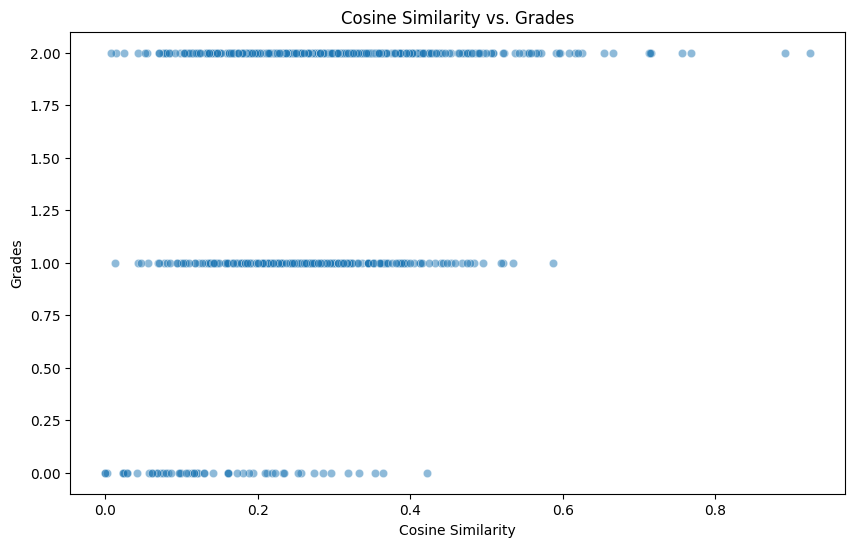

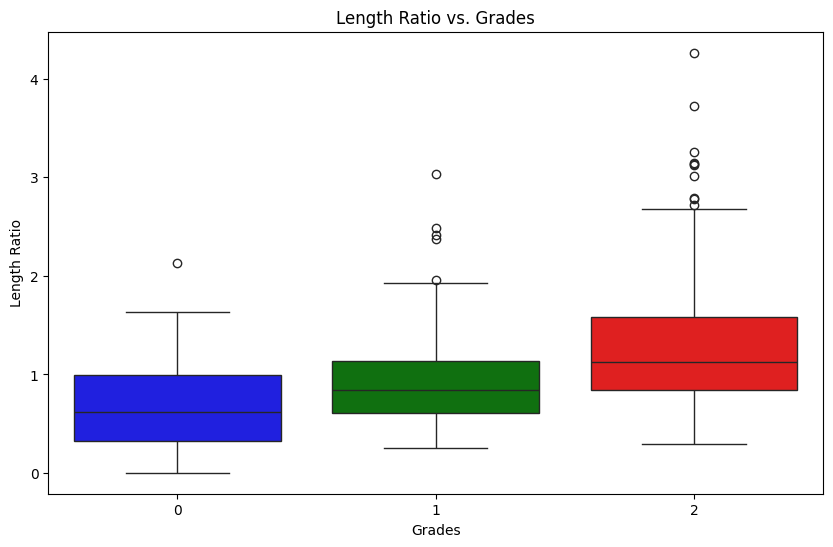

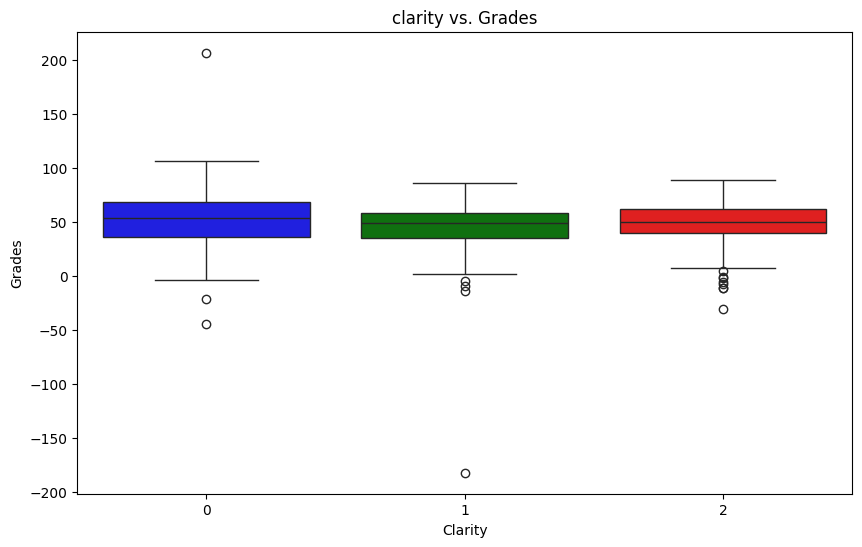

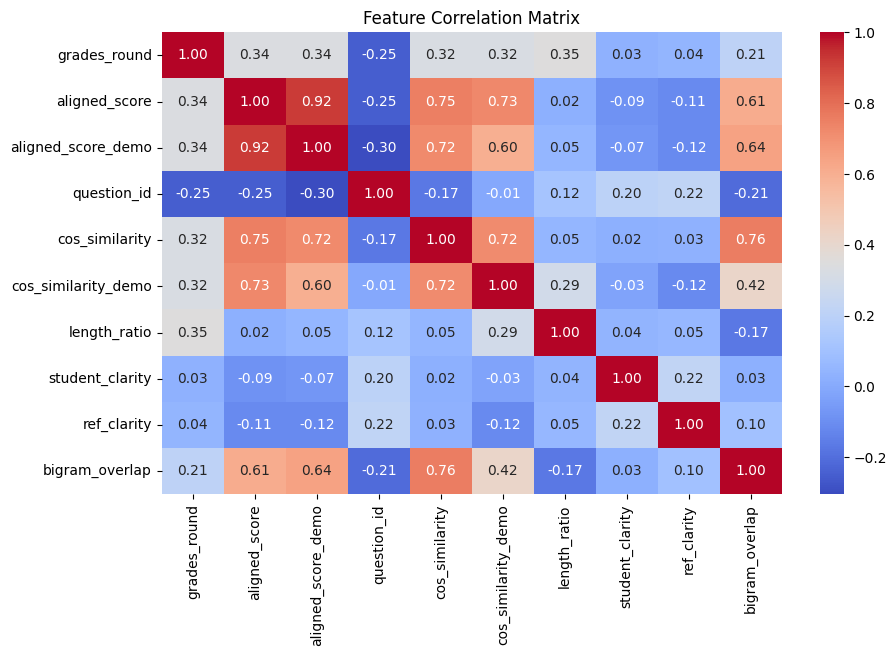

In [ ]:
#grade Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df["grades_round"], bins=10, kde=True, color="blue")
plt.title("Distribution of Student Grades")
plt.xlabel("Grade")
plt.ylabel("Frequency")
plt.show()

#  Cosine Similarity vs. Grades
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["cos_similarity"], y=df["grades_round"], alpha=0.5)
plt.title("Cosine Similarity vs. Grades")
plt.xlabel("Cosine Similarity")
plt.ylabel("Grades")
plt.show()

#  Length Ratio Analysis
plt.figure(figsize=(10,6))
sns.boxplot(x=df['grades_round'], y=df['length_ratio'], data=df, hue=df['grades_round'], palette=['blue', 'green', 'red'], legend=False)
plt.title("Length Ratio vs. Grades")
plt.xlabel("Grades")
plt.ylabel("Length Ratio")
plt.show()

#  Clarity Ratio Analysis
plt.figure(figsize=(10,6))
sns.boxplot(x=df['grades_round'], y=df['student_clarity'], data=df, hue=df['grades_round'], palette=['blue', 'green', 'red'], legend=False)
plt.title("clarity vs. Grades")
plt.xlabel("Clarity")
plt.ylabel("Grades")
plt.show()

#Feature Correlation
numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
import torch
from transformers import BertModel, BertTokenizer

# Load BERT Model & Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

# Function to Get BERT Embeddings
def get_bert_embedding(text):
    if not isinstance(text, str) or pd.isna(text):
        text = ""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Apply BERT Embedding Extraction
df["bert_stud"] = df["student_modified"].astype(str).apply(get_bert_embedding)
df["bert_ref"] = df["ref_modified"].astype(str).apply(get_bert_embedding)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
print(df.columns)

Index(['question', 'student_answer', 'grades_round', 'ref_answer', 'aligned',
       'aligned_score', 'aligned_score_demo', 'question_id', 'cos_similarity',
       'cos_similarity_demo', 'length_ratio', 'student_modified',
       'ref_modified', 'student_clarity', 'ref_clarity', 'bigram_overlap',
       'bert_stud', 'bert_ref'],
      dtype='object')


In [ ]:
# Convert list-based embeddings to numpy arrays
bert_stud_embeddings = np.array(df["bert_stud"].tolist(), dtype=np.float32)
bert_ref_embeddings = np.array(df["bert_ref"].tolist(), dtype=np.float32)

# Convert handcrafted features to NumPy array
handcrafted_features = df[[ "length_ratio", "aligned_score","cos_similarity","bigram_overlap"]].astype(np.float32).values

# Stack BERT embeddings with handcrafted features
X = np.hstack([bert_stud_embeddings, bert_ref_embeddings, handcrafted_features])

# Convert to PyTorch tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(df["grades_round"].values, dtype=torch.float32)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("Final Feature Matrix Shape:", X.shape)
print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)
print("Train Labels Shape:", y_train.shape)
print("Test Labels Shape:", y_test.shape)

Final Feature Matrix Shape: torch.Size([607, 1540])
Train Shape: torch.Size([485, 1540])
Test Shape: torch.Size([122, 1540])
Train Labels Shape: torch.Size([485])
Test Labels Shape: torch.Size([122])


In [ ]:
print("0:", torch.sum(y_train == 0).item())
print("1:", torch.sum(y_train == 1).item())
print("2:", torch.sum(y_train== 2).item())

0: 41
1: 177
2: 267


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.float32)
print("0:", torch.sum(y_train_resampled == 0).item())
print("1:", torch.sum(y_train_resampled == 1).item())
print("2:", torch.sum(y_train_resampled== 2).item())
print("Train Shape:", X_train_resampled.shape)
print("Test Shape:", y_train_resampled.shape)
print("Train Labels Shape:", y_train.shape)
print("Test Labels Shape:", y_test.shape)

0: 267
1: 267
2: 267
Train Shape: torch.Size([801, 1540])
Test Shape: torch.Size([801])
Train Labels Shape: torch.Size([485])
Test Labels Shape: torch.Size([122])


In [63]:
import torch.nn as nn
import torch.optim as optim

class HybridGradingModel(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.2):
        super(HybridGradingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 768)
        self.bn1 = nn.BatchNorm1d(768)
        self.activ = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(768, 384)
        self.bn2 = nn.BatchNorm1d(384)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(384, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4= nn.Dropout(dropout_rate)

        self.fc5= nn.Linear(64, 1)  # Regression Output

    def forward(self, x):
        x = self.activ(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.activ(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.activ(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.activ(self.bn4(self.fc4(x)))
        x= self.dropout4(x)
        x = self.fc5(x)
        return x


# Initialize Model
model = HybridGradingModel(input_dim=1540)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)

from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_train_resampled, y_train_resampled)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True,drop_last=True)

# training loop
def train_model(model, train_loader, epochs=80):
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


train_model(model, train_loader)

# Save Model
torch.save(model.state_dict(), "hybrid_model.pth")
print("Model Training Completed & Saved")


Epoch 0, Loss: 0.9112
Epoch 10, Loss: 0.2015
Epoch 20, Loss: 0.1618
Epoch 30, Loss: 0.1071
Epoch 40, Loss: 0.0657
Epoch 50, Loss: 0.0698
Epoch 60, Loss: 0.0359
Epoch 70, Loss: 0.0257
Model Training Completed & Saved


In [64]:
from sklearn.metrics import accuracy_score,mean_absolute_error

# Model Evaluation
model.eval()
y_pred = model(X_test).detach().numpy().squeeze()
y_pred_rounded = np.round(y_pred)

# Compute accuracy
print(f"\nEvaluation Results:")
accuracy = accuracy_score(y_test, y_pred_rounded) * 100
print(f"Accuracy: {accuracy:.2f}%")
mae = mean_absolute_error(y_test, y_pred_rounded)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Fairness Analysis: Correlation Between Scores & Features
correlation_matrix = df[["grades_round", "cos_similarity", "length_ratio", "student_clarity","aligned_score","bigram_overlap"]].corr()
print("\nFeature Correlations with Grades:")
print(correlation_matrix)


Evaluation Results:
Accuracy: 68.03%
Mean Absolute Error (MAE): 0.3607

Feature Correlations with Grades:
                 grades_round  cos_similarity  length_ratio  student_clarity  \
grades_round         1.000000        0.323190      0.349448         0.027130   
cos_similarity       0.323190        1.000000      0.050110         0.022426   
length_ratio         0.349448        0.050110      1.000000         0.040460   
student_clarity      0.027130        0.022426      0.040460         1.000000   
aligned_score        0.335900        0.754932      0.022785        -0.087334   
bigram_overlap       0.207717        0.757430     -0.167156         0.026397   

                 aligned_score  bigram_overlap  
grades_round          0.335900        0.207717  
cos_similarity        0.754932        0.757430  
length_ratio          0.022785       -0.167156  
student_clarity      -0.087334        0.026397  
aligned_score         1.000000        0.611435  
bigram_overlap        0.611435        

In [65]:
print("Comparing model's score after rounding off with actual score")
for pred, actual in zip(y_pred_rounded, y_test):
    print(f"Predicted: {pred}, Actual: {actual}")


Comparing model's score after rounding off with actual score
Predicted: 2.0, Actual: 0.0
Predicted: 2.0, Actual: 2.0
Predicted: 2.0, Actual: 2.0
Predicted: 2.0, Actual: 1.0
Predicted: 1.0, Actual: 1.0
Predicted: 1.0, Actual: 1.0
Predicted: 1.0, Actual: 1.0
Predicted: 1.0, Actual: 1.0
Predicted: 2.0, Actual: 2.0
Predicted: 2.0, Actual: 0.0
Predicted: 1.0, Actual: 2.0
Predicted: 0.0, Actual: 0.0
Predicted: 2.0, Actual: 2.0
Predicted: 1.0, Actual: 2.0
Predicted: 2.0, Actual: 2.0
Predicted: 2.0, Actual: 2.0
Predicted: 2.0, Actual: 1.0
Predicted: 2.0, Actual: 1.0
Predicted: 2.0, Actual: 2.0
Predicted: 1.0, Actual: 2.0
Predicted: 1.0, Actual: 1.0
Predicted: 1.0, Actual: 1.0
Predicted: 1.0, Actual: 1.0
Predicted: 1.0, Actual: 1.0
Predicted: 2.0, Actual: 1.0
Predicted: 1.0, Actual: 2.0
Predicted: 1.0, Actual: 1.0
Predicted: 2.0, Actual: 2.0
Predicted: 1.0, Actual: 2.0
Predicted: 2.0, Actual: 2.0
Predicted: 2.0, Actual: 1.0
Predicted: 2.0, Actual: 2.0
Predicted: 2.0, Actual: 2.0
Predicted: 2.0,